Loading image for statistics...
Extracting objects...
Found 331 objects
Merging all statistics...
Calculating spectral statistics...
Calculating geometric statistics...
Calculating texture statistics...
Statistics calculated for 331 objects


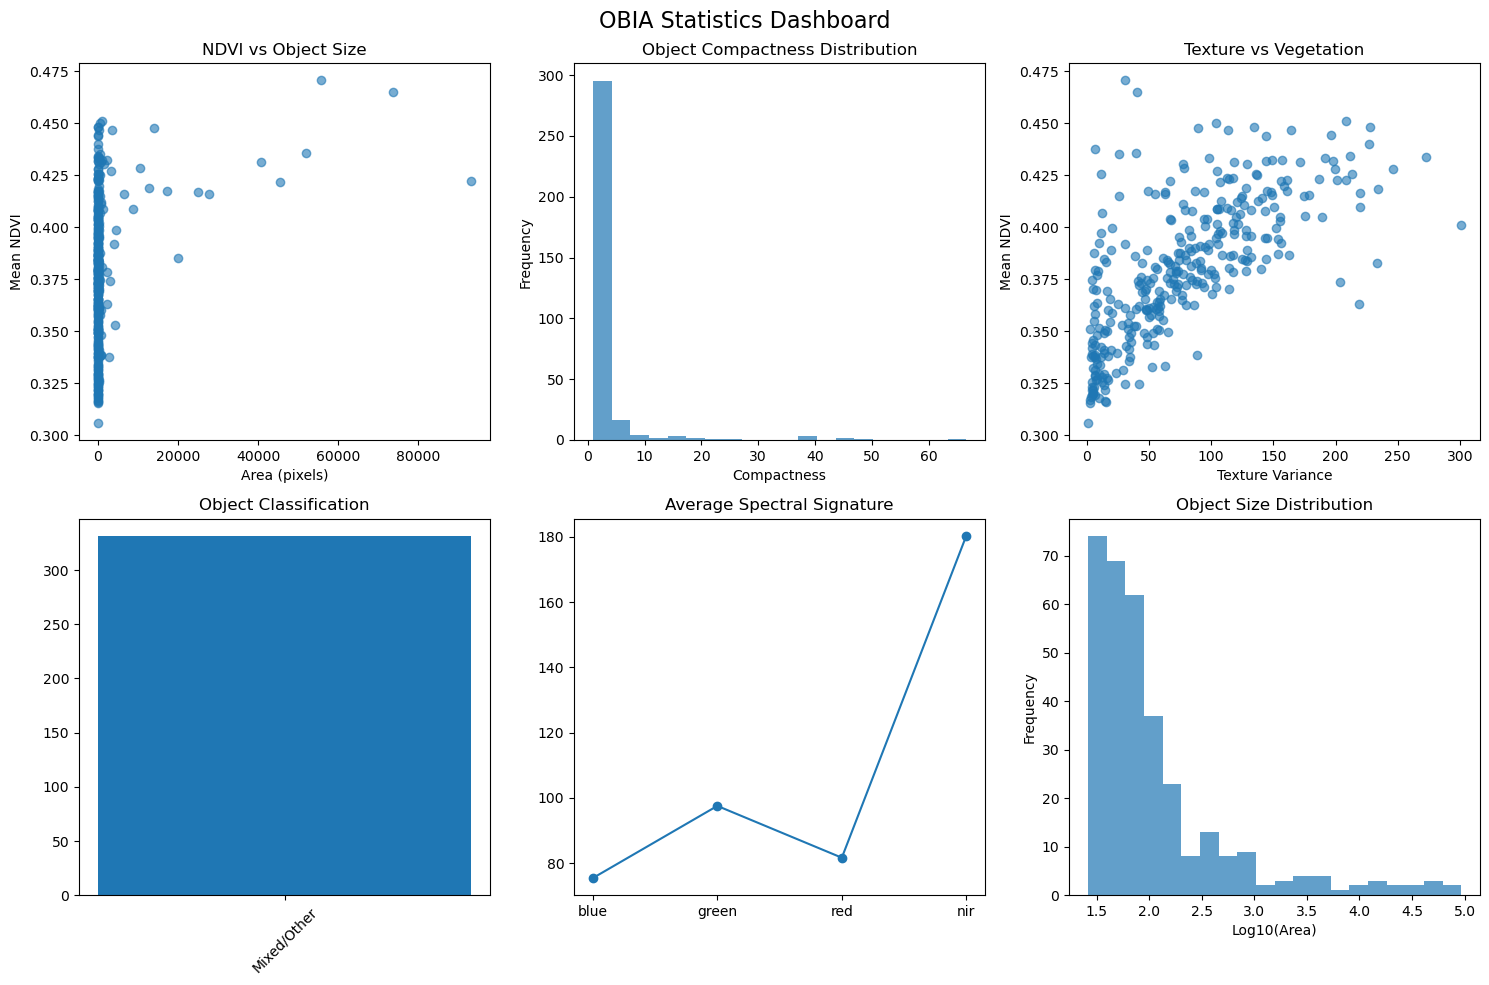


=== OBIA STATISTICS SUMMARY ===
Total objects analyzed: 331
Total area covered: 577551.0 pixels
Average object size: 1744.9 pixels
Size range: 26.0 - 93222.0 pixels

Spectral Statistics:
Mean NDVI: 0.380 ± 0.034
Mean NDWI: -0.305 ± 0.040

Classification Results:
  Mixed/Other: 331 objects (100.0%)


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import measure, morphology
from scipy import ndimage
import rasterio
from collections import defaultdict

class OBIAStatistics:
    def __init__(self, image_path, segments=None):
        """
        Initialize OBIA statistics workflow
        
        Args:
            image_path: Path to Sentinel-2 image
            segments: Segmentation array (optional)
        """
        self.image_path = image_path
        self.bands = {}
        self.indices = {}
        self.segments = segments
        self.stats_df = None
        self.objects = None
        
    def load_image(self):
        """Load Sentinel-2 image and extract bands"""
        print("Loading image for statistics...")
        
        with rasterio.open(self.image_path) as src:
            self.bands['blue'] = src.read(3).astype(np.float32)
            self.bands['green'] = src.read(2).astype(np.float32)
            self.bands['red'] = src.read(1).astype(np.float32)
            self.bands['nir'] = src.read(4).astype(np.float32)
            
    def calculate_indices(self):
        """Calculate spectral indices"""
        # NDVI
        ndvi_num = self.bands['nir'] - self.bands['red']
        ndvi_den = self.bands['nir'] + self.bands['red']
        self.indices['ndvi'] = np.divide(ndvi_num, ndvi_den, 
                                       out=np.zeros_like(ndvi_num), 
                                       where=ndvi_den!=0)
        
        # NDWI
        ndwi_num = self.bands['green'] - self.bands['nir']
        ndwi_den = self.bands['green'] + self.bands['nir']
        self.indices['ndwi'] = np.divide(ndwi_num, ndwi_den,
                                       out=np.zeros_like(ndwi_num),
                                       where=ndwi_den!=0)
        
        # Enhanced Vegetation Index (EVI)
        evi_num = 2.5 * (self.bands['nir'] - self.bands['red'])
        evi_den = self.bands['nir'] + 6 * self.bands['red'] - 7.5 * self.bands['blue'] + 1
        self.indices['evi'] = np.divide(evi_num, evi_den,
                                      out=np.zeros_like(evi_num),
                                      where=evi_den!=0)
        
    def extract_objects(self):
        """Extract individual objects from segments"""
        print("Extracting objects...")
        
        if self.segments is None:
            # Simple threshold segmentation if no segments provided
            self.indices['ndvi'] = self.indices.get('ndvi', self._calculate_ndvi())
            binary = self.indices['ndvi'] > 0.3
            binary = morphology.opening(binary, morphology.disk(3))
            self.segments = measure.label(binary)
            
        # Get object properties
        self.objects = measure.regionprops(self.segments)
        print(f"Found {len(self.objects)} objects")
        
    def _calculate_ndvi(self):
        """Helper to calculate NDVI if not already done"""
        ndvi_num = self.bands['nir'] - self.bands['red']
        ndvi_den = self.bands['nir'] + self.bands['red']
        return np.divide(ndvi_num, ndvi_den, 
                        out=np.zeros_like(ndvi_num), 
                        where=ndvi_den!=0)
        
    def calculate_spectral_stats(self):
        """Calculate spectral statistics for each object"""
        print("Calculating spectral statistics...")
        
        stats_list = []
        
        for obj in self.objects:
            if obj.area < 10:  # Skip very small objects
                continue
                
            mask = self.segments == obj.label
            stats = {'object_id': obj.label}
            
            # Basic spectral statistics
            for band_name, band_data in self.bands.items():
                values = band_data[mask]
                stats[f'{band_name}_mean'] = np.mean(values)
                stats[f'{band_name}_std'] = np.std(values)
                stats[f'{band_name}_median'] = np.median(values)
                
            # Index statistics
            for idx_name, idx_data in self.indices.items():
                values = idx_data[mask]
                stats[f'{idx_name}_mean'] = np.mean(values)
                stats[f'{idx_name}_std'] = np.std(values)
                
            stats_list.append(stats)
            
        return pd.DataFrame(stats_list)
        
    def calculate_geometric_stats(self):
        """Calculate geometric/shape statistics"""
        print("Calculating geometric statistics...")
        
        geo_stats = []
        
        for obj in self.objects:
            if obj.area < 10:
                continue
                
            stats = {
                'object_id': obj.label,
                'area': obj.area,
                'perimeter': obj.perimeter,
                'compactness': (obj.perimeter ** 2) / (4 * np.pi * obj.area),
                'eccentricity': obj.eccentricity,
                'solidity': obj.solidity,
                'extent': obj.extent,
                'aspect_ratio': obj.major_axis_length / obj.minor_axis_length if obj.minor_axis_length > 0 else 0
            }
            
            geo_stats.append(stats)
            
        return pd.DataFrame(geo_stats)
        
    def calculate_texture_stats(self):
        """Calculate basic texture statistics"""
        print("Calculating texture statistics...")
        
        texture_stats = []
        
        # Use NIR band for texture analysis
        nir_band = self.bands['nir']
        
        for obj in self.objects:
            if obj.area < 10:
                continue
                
            mask = self.segments == obj.label
            
            # Get bounding box for local calculations
            minr, minc, maxr, maxc = obj.bbox
            local_mask = mask[minr:maxr, minc:maxc]
            local_nir = nir_band[minr:maxr, minc:maxc]
            
            # Simple texture measures
            if np.sum(local_mask) > 0:
                # Local variance (texture measure)
                local_var = ndimage.generic_filter(local_nir, np.var, size=3)
                texture_variance = np.mean(local_var[local_mask])
                
                # Range
                texture_range = np.ptp(local_nir[local_mask])
                
                stats = {
                    'object_id': obj.label,
                    'texture_variance': texture_variance,
                    'texture_range': texture_range,
                    'homogeneity': 1 / (1 + texture_variance) if texture_variance > 0 else 1
                }
                
                texture_stats.append(stats)
                
        return pd.DataFrame(texture_stats)
        
    def merge_all_stats(self):
        """Combine all statistics into single dataframe"""
        print("Merging all statistics...")
        
        spectral_df = self.calculate_spectral_stats()
        geometric_df = self.calculate_geometric_stats()
        texture_df = self.calculate_texture_stats()
        
        # Merge dataframes
        self.stats_df = spectral_df
        self.stats_df = self.stats_df.merge(geometric_df, on='object_id', how='left')
        self.stats_df = self.stats_df.merge(texture_df, on='object_id', how='left')
        
        print(f"Statistics calculated for {len(self.stats_df)} objects")
        return self.stats_df
        
    def classify_objects(self):
        """Simple rule-based classification of objects"""
        if self.stats_df is None:
            self.merge_all_stats()
            
        conditions = [
            (self.stats_df['ndvi_mean'] > 0.6) & (self.stats_df['area'] > 100),
            (self.stats_df['ndwi_mean'] > 0.3) & (self.stats_df['ndvi_mean'] < 0.2),
            (self.stats_df['ndvi_mean'] < 0.2) & (self.stats_df['red_mean'] > self.stats_df['nir_mean']),
            (self.stats_df['compactness'] < 1.5) & (self.stats_df['area'] > 500)
        ]
        
        choices = ['Dense Vegetation', 'Water', 'Built-up/Bare', 'Large Structure']
        
        self.stats_df['class'] = np.select(conditions, choices, default='Mixed/Other')
        
        return self.stats_df['class'].value_counts()
        
    def plot_statistics(self):
        """Visualize key statistics"""
        if self.stats_df is None:
            self.merge_all_stats()
            
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        fig.suptitle('OBIA Statistics Dashboard', fontsize=16)
        
        # NDVI vs Area
        axes[0, 0].scatter(self.stats_df['area'], self.stats_df['ndvi_mean'], alpha=0.6)
        axes[0, 0].set_xlabel('Area (pixels)')
        axes[0, 0].set_ylabel('Mean NDVI')
        axes[0, 0].set_title('NDVI vs Object Size')
        
        # Compactness distribution
        axes[0, 1].hist(self.stats_df['compactness'], bins=20, alpha=0.7)
        axes[0, 1].set_xlabel('Compactness')
        axes[0, 1].set_ylabel('Frequency')
        axes[0, 1].set_title('Object Compactness Distribution')
        
        # Texture variance vs NDVI
        if 'texture_variance' in self.stats_df.columns:
            axes[0, 2].scatter(self.stats_df['texture_variance'], 
                             self.stats_df['ndvi_mean'], alpha=0.6)
            axes[0, 2].set_xlabel('Texture Variance')
            axes[0, 2].set_ylabel('Mean NDVI')
            axes[0, 2].set_title('Texture vs Vegetation')
        
        # Classification results
        if 'class' in self.stats_df.columns:
            class_counts = self.stats_df['class'].value_counts()
            axes[1, 0].bar(range(len(class_counts)), class_counts.values)
            axes[1, 0].set_xticks(range(len(class_counts)))
            axes[1, 0].set_xticklabels(class_counts.index, rotation=45)
            axes[1, 0].set_title('Object Classification')
        
        # Spectral signature comparison
        spectral_cols = [col for col in self.stats_df.columns if col.endswith('_mean') and 
                        col.split('_')[0] in ['blue', 'green', 'red', 'nir']]
        
        if len(spectral_cols) > 0:
            mean_signature = self.stats_df[spectral_cols].mean()
            axes[1, 1].plot(range(len(mean_signature)), mean_signature.values, 'o-')
            axes[1, 1].set_xticks(range(len(mean_signature)))
            axes[1, 1].set_xticklabels([col.replace('_mean', '') for col in spectral_cols])
            axes[1, 1].set_title('Average Spectral Signature')
        
        # Size distribution
        axes[1, 2].hist(np.log10(self.stats_df['area']), bins=20, alpha=0.7)
        axes[1, 2].set_xlabel('Log10(Area)')
        axes[1, 2].set_ylabel('Frequency')
        axes[1, 2].set_title('Object Size Distribution')
        
        plt.tight_layout()
        plt.show()
        
    def export_stats(self, output_path):
        """Export statistics to CSV"""
        if self.stats_df is None:
            self.merge_all_stats()
            
        self.stats_df.to_csv(output_path, index=False)
        print(f"Statistics exported to {output_path}")
        
    def summary_report(self):
        """Generate summary report"""
        if self.stats_df is None:
            self.merge_all_stats()
            
        print("\n=== OBIA STATISTICS SUMMARY ===")
        print(f"Total objects analyzed: {len(self.stats_df)}")
        print(f"Total area covered: {self.stats_df['area'].sum()} pixels")
        print(f"Average object size: {self.stats_df['area'].mean():.1f} pixels")
        print(f"Size range: {self.stats_df['area'].min()} - {self.stats_df['area'].max()} pixels")
        
        print(f"\nSpectral Statistics:")
        print(f"Mean NDVI: {self.stats_df['ndvi_mean'].mean():.3f} ± {self.stats_df['ndvi_mean'].std():.3f}")
        print(f"Mean NDWI: {self.stats_df['ndwi_mean'].mean():.3f} ± {self.stats_df['ndwi_mean'].std():.3f}")
        
        if 'class' in self.stats_df.columns:
            print(f"\nClassification Results:")
            for class_name, count in self.stats_df['class'].value_counts().items():
                percentage = (count / len(self.stats_df)) * 100
                print(f"  {class_name}: {count} objects ({percentage:.1f}%)")


# Main workflow function
def run_obia_statistics(image_path, segments=None):
    """
    Run complete OBIA statistics workflow
    
    Args:
        image_path: Path to Sentinel-2 image
        segments: Optional segmentation array
    """
    
    # Initialize
    stats_analyzer = OBIAStatistics(image_path, segments)
    
    # Load and process
    stats_analyzer.load_image()
    stats_analyzer.calculate_indices()
    stats_analyzer.extract_objects()
    
    # Calculate all statistics
    stats_df = stats_analyzer.merge_all_stats()
    
    # Classify objects
    class_counts = stats_analyzer.classify_objects()
    
    # Generate visualizations and summary
    stats_analyzer.plot_statistics()
    stats_analyzer.summary_report()
    
    return stats_analyzer

# Example usage:
stats = run_obia_statistics('/Users/devseed/Documents/repos/OBIA_workflow/data/ortho_subset_I.tif')
# stats.export_stats('obia_statistics.csv')